# Descriptive Analysis

**Note:** This notebook analyzes which in-match performance statistics explain match outcomes. It is explanatory, not predictive, and intentionally includes post-match features.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load the cleaned dataset
data_path = Path("../data/clean/atp_matches_cleaned.csv")
df = pd.read_csv(data_path)

print(f"Loaded {len(df):,} records")


Loaded 288,042 records


In [2]:
# Compute mean for each delta feature for winners and losers
delta_cols = [c for c in df.columns if c.startswith('delta_')]

# Separate winners and losers
winners = df[df['win'] == 1]
losers = df[df['win'] == 0]

# Calculate means
winner_means = winners[delta_cols].mean()
loser_means = losers[delta_cols].mean()

# Create comparison table
comparison_df = pd.DataFrame({
    'delta_feature': delta_cols,
    'mean_winners': winner_means.values,
    'mean_losers': loser_means.values
})

# Round to 3 decimal places for readability
comparison_df['mean_winners'] = comparison_df['mean_winners'].round(3)
comparison_df['mean_losers'] = comparison_df['mean_losers'].round(3)

print("Mean delta features for winners vs losers:")
print("=" * 60)
print(comparison_df.to_string(index=False))


Mean delta features for winners vs losers:
    delta_feature  mean_winners  mean_losers
       delta_svpt        -2.510        2.510
         delta_ht         0.497       -0.497
       delta_rank       -56.174       56.174
        delta_ace         1.450       -1.450
      delta_1stIn        -0.368        0.368
     delta_1stWon         3.862       -3.862
    delta_bpSaved        -1.170        1.170
         delta_df        -0.713        0.713
delta_rank_points       304.837     -304.837
        delta_age         0.007       -0.007
      delta_SvGms         0.185       -0.185
     delta_2ndWon         1.642       -1.642
    delta_bpFaced        -3.371        3.371


In [3]:
# Calculate Cohen's d for each delta feature (effect size between winners and losers)
from scipy import stats

cohens_d_results = []

for delta_col in delta_cols:
    winner_values = winners[delta_col].dropna()
    loser_values = losers[delta_col].dropna()
    
    # Calculate means and standard deviations
    mean_w = winner_values.mean()
    mean_l = loser_values.mean()
    std_w = winner_values.std()
    std_l = loser_values.std()
    n_w = len(winner_values)
    n_l = len(loser_values)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n_w - 1) * std_w**2 + (n_l - 1) * std_l**2) / (n_w + n_l - 2))
    
    # Cohen's d
    if pooled_std > 0:
        cohens_d = (mean_w - mean_l) / pooled_std
    else:
        cohens_d = np.nan
    
    cohens_d_results.append({
        'delta_feature': delta_col,
        'cohens_d': cohens_d
    })

cohens_d_df = pd.DataFrame(cohens_d_results)
cohens_d_df['cohens_d'] = cohens_d_df['cohens_d'].round(3)

# Sort by absolute value of Cohen's d (largest effect sizes first)
cohens_d_df['abs_cohens_d'] = cohens_d_df['cohens_d'].abs()
cohens_d_df = cohens_d_df.sort_values('abs_cohens_d', ascending=False).drop(columns='abs_cohens_d')

print("Cohen's d for delta features (winners vs losers):")
print("=" * 60)
print("Interpretation: |d| < 0.2 = small, 0.2-0.5 = medium, 0.5-0.8 = large, > 0.8 = very large")
print("-" * 60)
print(cohens_d_df.to_string(index=False))


Cohen's d for delta features (winners vs losers):
Interpretation: |d| < 0.2 = small, 0.2-0.5 = medium, 0.5-0.8 = large, > 0.8 = very large
------------------------------------------------------------
    delta_feature  cohens_d
    delta_bpFaced    -1.533
     delta_1stWon     1.117
    delta_bpSaved    -0.596
     delta_2ndWon     0.592
        delta_ace     0.558
      delta_SvGms     0.533
         delta_df    -0.499
       delta_rank    -0.491
delta_rank_points     0.437
       delta_svpt    -0.386
         delta_ht     0.097
      delta_1stIn    -0.067
        delta_age     0.003


In [4]:
# Drop delta_ht, delta_1stIn, and delta_age
columns_to_drop = ['delta_ht', 'delta_1stIn', 'delta_age']
df_relevant = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

print(f"Dropped columns: {[col for col in columns_to_drop if col in df.columns]}")
print(f"Remaining columns: {len(df_relevant.columns)}")
print(f"Rows: {len(df_relevant):,}")

# Save to new dataset
output_path = Path("../data/clean/atp_matches_relevant.csv")
df_relevant.to_csv(output_path, index=False)

print(f"\nSaved to: {output_path}")


Dropped columns: ['delta_ht', 'delta_1stIn', 'delta_age']
Remaining columns: 63
Rows: 288,042

Saved to: ..\data\clean\atp_matches_relevant.csv


In [5]:
# Select core delta features and define target variable
delta_features = [c for c in df_relevant.columns if c.startswith('delta_')]
X = df_relevant[delta_features]
y = df_relevant['win']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nNumber of features: {len(delta_features)}")
print(f"Features: {delta_features}")
print(f"\nTarget distribution:")
print(y.value_counts().sort_index())


Feature matrix shape: (288042, 10)
Target variable shape: (288042,)

Number of features: 10
Features: ['delta_svpt', 'delta_rank', 'delta_ace', 'delta_1stWon', 'delta_bpSaved', 'delta_df', 'delta_rank_points', 'delta_SvGms', 'delta_2ndWon', 'delta_bpFaced']

Target distribution:
win
0    144021
1    144021
Name: count, dtype: int64


In [8]:
# Time-based train/test split (train on matches through 2022, test on 2023+)
# Extract year from the dataset
df_relevant['year'] = pd.to_numeric(
    df_relevant['tourney_date'].astype(str).str[:4], 
    errors='coerce'
)

# Create train/test masks
train_mask = df_relevant['year'] <= 2022
test_mask = df_relevant['year'] >= 2023

# Split features and target
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Train set: {len(X_train):,} samples (years <= 2022)")
print(f"Test set:  {len(X_test):,} samples (years >= 2023)")
print(f"\nTrain set year range: {df_relevant[train_mask]['year'].min():.0f} - {df_relevant[train_mask]['year'].max():.0f}")
print(f"Test set year range:  {df_relevant[test_mask]['year'].min():.0f} - {df_relevant[test_mask]['year'].max():.0f}")
print(f"\nTrain target distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest target distribution:")
print(y_test.value_counts().sort_index())


Train set: 236,928 samples (years <= 2022)
Test set:  51,114 samples (years >= 2023)

Train set year range: 2006 - 2022
Test set year range:  2023 - 2024

Train target distribution:
win
0    118464
1    118464
Name: count, dtype: int64

Test target distribution:
win
0    25557
1    25557
Name: count, dtype: int64


In [9]:
# Standardize features using StandardScaler
from sklearn.preprocessing import StandardScaler

# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features standardized:")
print(f"Train set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"\nTrain set statistics (first 5 features):")
print(X_train_scaled.iloc[:, :5].describe().loc[['mean', 'std']])


Features standardized:
Train set shape: (236928, 10)
Test set shape: (51114, 10)

Train set statistics (first 5 features):
        delta_svpt    delta_rank     delta_ace  delta_1stWon  delta_bpSaved
mean -4.798371e-18 -5.758045e-18 -2.015316e-17  4.414501e-17   2.015316e-17
std   1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   1.000002e+00


In [10]:
# Train logistic regression model
from sklearn.linear_model import LogisticRegression

# Use C=1.0 for moderate regularization (default)
# Lower C = stronger regularization
lr_model = LogisticRegression(C=1.0, random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

print("Logistic Regression Model Trained")
print(f"Number of iterations: {lr_model.n_iter_[0]}")
print(f"Regularization strength (C): {lr_model.C}")

# Get coefficients
coefficients = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': lr_model.coef_[0]
})

# Sort by absolute value of coefficient
coefficients['abs_coefficient'] = coefficients['coefficient'].abs()
coefficients = coefficients.sort_values('abs_coefficient', ascending=False).drop(columns='abs_coefficient')

print("\nModel Coefficients (sorted by absolute value):")
print("=" * 60)
print(coefficients.to_string(index=False))


Logistic Regression Model Trained
Number of iterations: 18
Regularization strength (C): 1.0

Model Coefficients (sorted by absolute value):
          feature  coefficient
     delta_1stWon     4.766329
    delta_bpFaced    -3.815664
     delta_2ndWon     3.464403
       delta_svpt    -3.239274
    delta_bpSaved     2.519469
      delta_SvGms    -0.083046
       delta_rank    -0.071054
        delta_ace    -0.065282
delta_rank_points     0.036387
         delta_df    -0.011145


In [11]:
# Create table with coefficients and odds ratios
coef_table = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': lr_model.coef_[0],
    'odds_ratio': np.exp(lr_model.coef_[0])
})

# Sort by absolute coefficient value
coef_table['abs_coefficient'] = coef_table['coefficient'].abs()
coef_table = coef_table.sort_values('abs_coefficient', ascending=False).drop(columns='abs_coefficient')

# Round for readability
coef_table['coefficient'] = coef_table['coefficient'].round(4)
coef_table['odds_ratio'] = coef_table['odds_ratio'].round(4)

print("Logistic Regression Coefficients and Odds Ratios:")
print("=" * 70)
print("Interpretation:")
print("  - Coefficient: change in log-odds per unit increase in standardized feature")
print("  - Odds Ratio: multiplicative change in odds per unit increase")
print("  - OR > 1: increases win probability, OR < 1: decreases win probability")
print("-" * 70)
print(coef_table.to_string(index=False))


Logistic Regression Coefficients and Odds Ratios:
Interpretation:
  - Coefficient: change in log-odds per unit increase in standardized feature
  - Odds Ratio: multiplicative change in odds per unit increase
  - OR > 1: increases win probability, OR < 1: decreases win probability
----------------------------------------------------------------------
          feature  coefficient  odds_ratio
     delta_1stWon       4.7663    117.4871
    delta_bpFaced      -3.8157      0.0220
     delta_2ndWon       3.4644     31.9574
       delta_svpt      -3.2393      0.0392
    delta_bpSaved       2.5195     12.4220
      delta_SvGms      -0.0830      0.9203
       delta_rank      -0.0711      0.9314
        delta_ace      -0.0653      0.9368
delta_rank_points       0.0364      1.0371
         delta_df      -0.0111      0.9889


Model Performance on Test Set:
ROC AUC: 0.9918
Log Loss: 0.1155


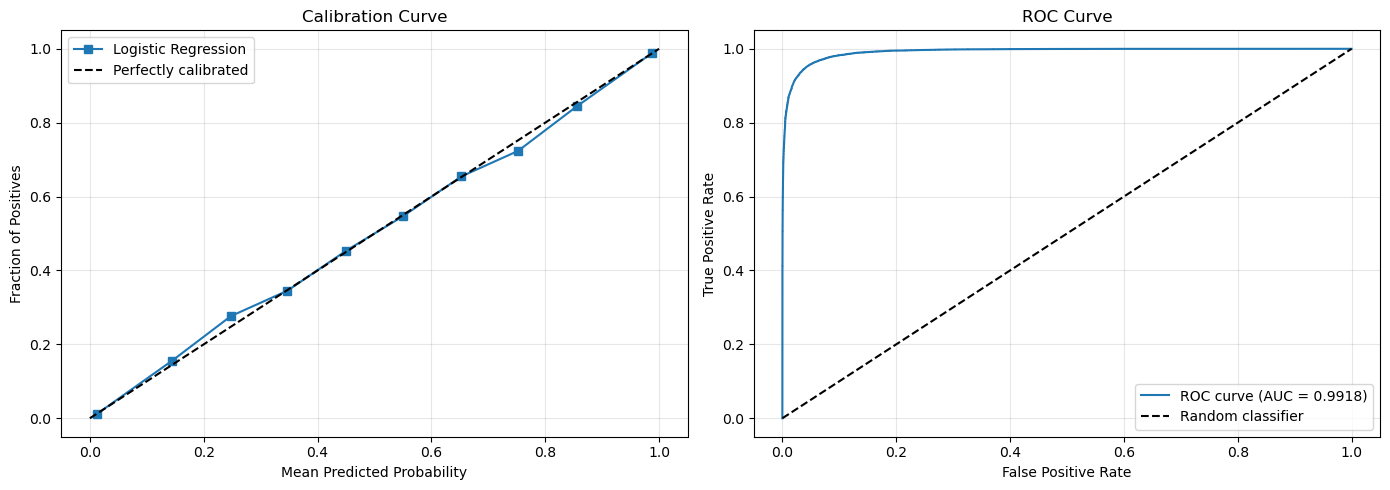

In [12]:
# Evaluate logistic regression model
from sklearn.metrics import roc_auc_score, log_loss, roc_curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Get predictions and probabilities
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
log_loss_score = log_loss(y_test, y_pred_proba)

print("Model Performance on Test Set:")
print("=" * 50)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Log Loss: {log_loss_score:.4f}")

# Plot calibration curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_pred_proba, n_bins=10, strategy='uniform'
)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic Regression")
ax1.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
ax1.set_xlabel("Mean Predicted Probability")
ax1.set_ylabel("Fraction of Positives")
ax1.set_title("Calibration Curve")
ax1.legend()
ax1.grid(True, alpha=0.3)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
ax2.plot([0, 1], [0, 1], "k--", label="Random classifier")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
